#### Ejercicio 6.1 imagen Saigon 

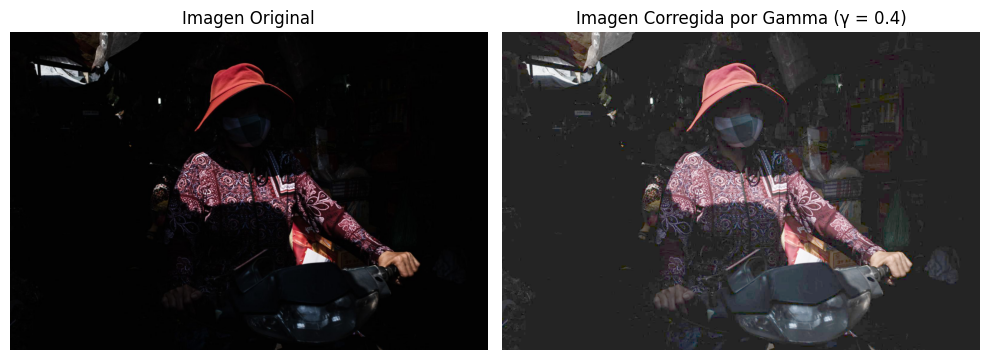

In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen desde un archivo
image_path = './imgs/saigon.jpeg'  # Ruta de la imagen
image = Image.open(image_path)  # Abrir la imagen usando PIL
image_array = np.array(image)  # Convertir la imagen a un array de numpy

def gamma_transformation(image_array, gamma):
    """
    Aplica una transformación de gamma a la imagen.
    
    :param image_array: Array de numpy con los datos de la imagen.
    :param gamma: Valor de gamma para la transformación.
    :return: Imagen transformada como un array de numpy.
    """
    # Normalizar los valores de píxeles a [0, 1]
    normalized_image = image_array / 255.0

    # Aplicar corrección de gamma
    gamma_corrected = normalized_image ** gamma

    # Convertir de vuelta a [0, 255] y a entero de 8 bits
    gamma_corrected_image = np.uint8(gamma_corrected * 255)

    return gamma_corrected_image

# Definir un valor de gamma (En este caso se aplica un valor < 1 para aclarar la imagen)
gamma_value = 0.4

# Aplicar transformación de gamma a la imagen
image_gamma_corrected = gamma_transformation(image_array, gamma_value)

# Convertir el array corregido por gamma de nuevo a una imagen
image_gamma_corrected_pil = Image.fromarray(image_gamma_corrected)

# Mostrar la imagen original y la imagen corregida por gamma
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)  # Imagen original
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(image_gamma_corrected_pil)  # Imagen corregida por gamma
axes[1].set_title(f'Imagen Corregida por Gamma (γ = {gamma_value})')
axes[1].axis('off')

plt.tight_layout()
plt.show()


#### Ejercicio 6.2 imagen Monkey

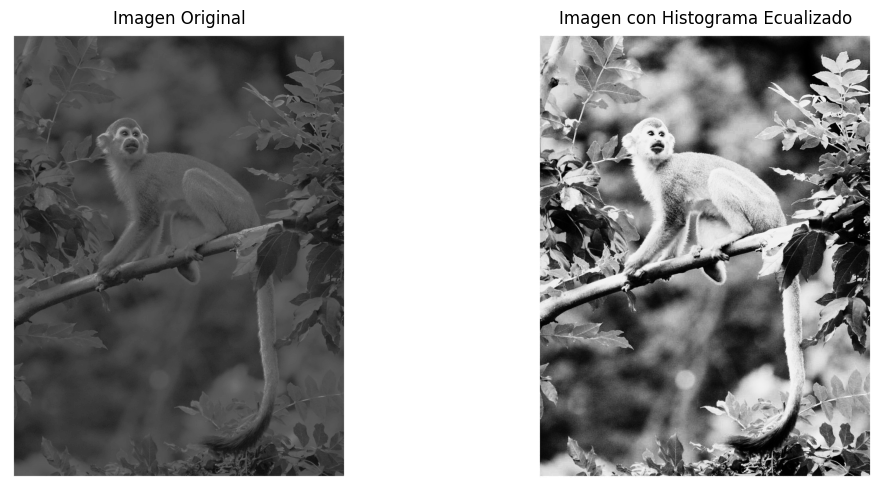

In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Cargar la imagen y convertirla a escala de grises
monkey_image_path = './imgs/monkey.jpeg'  # Cargar la imagen
monkey_image = Image.open(monkey_image_path).convert('L') # Convertir a escala de grises
monkey_array = np.array(monkey_image) # Convertir la imagen a un array de numpy

def histogram_equalization(image_array):
    # Aplanar el array de la imagen para convertirlo en una secuencia unidimensional de valores de píxeles
    flattened = image_array.flatten()

    # Calcular el histograma de la imagen aplanada con 256 bins (para cada valor de píxel posible de 0 a 255)
    histogram, bin_edges = np.histogram(flattened, bins=256, range=[0, 256])

    # Calcular la función de distribución acumulativa (CDF) a partir del histograma
    cdf = histogram.cumsum()

    # Normalizar la CDF para que su valor máximo sea igual al máximo valor en el histograma
    cdf_normalized = cdf * float(histogram.max()) / cdf.max()

    # Mapeo de los viejos valores de píxeles a nuevos valores utilizando la CDF normalizada
    # Primero, enmascaramos los valores cero en la CDF para evitar dividir por cero
    cdf_m = np.ma.masked_equal(cdf, 0)

    # Escalar la CDF enmascarada para que los valores vayan de 0 a 255
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())

    # Rellenar los valores enmascarados con 0 y convertir a enteros de 8 bits
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')

    # Mapear los píxeles originales a sus nuevos valores utilizando la CDF final
    image_equalized = cdf_final[flattened].reshape(image_array.shape)

    return image_equalized

# Aplicar la ecualización del histograma
monkey_equalized_array = histogram_equalization(monkey_array)

# Convertir de nuevo a imagen PIL para mostrarla
monkey_equalized_image = Image.fromarray(monkey_equalized_array)

# Mostrar la imagen original y la imagen con histograma ecualizado lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(monkey_image, cmap='gray')  # Mostrar imagen original
axes[0].set_title('Imagen Original')
axes[0].axis('off')  # Quitar los ejes

axes[1].imshow(monkey_equalized_image, cmap='gray')  # Mostrar imagen con histograma ecualizado
axes[1].set_title('Imagen con Histograma Ecualizado')
axes[1].axis('off')  # Quitar los ejes

plt.tight_layout()  # Ajustar automáticamente los parámetros del subtrazado
plt.show()  # Mostrar las imágenes


#### Ejercicio 6.3 imagen Rice

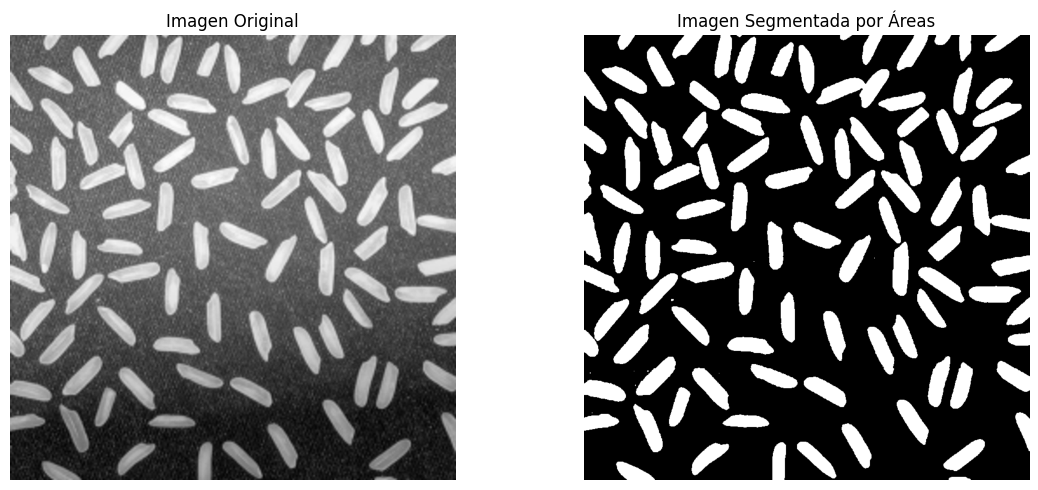

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen desde una ruta y convertirla a escala de grises
rice_image_path = './Imgs/rice.jpg'  # Ruta de la imagen
rice_image = Image.open(rice_image_path).convert('L')  # Convertir a escala de grises
rice_array = np.array(rice_image) # Convertir la imagen a un array de numpy

def otsu_threshold(region):
    """
    Calcula el umbral de Otsu para una región dada de la imagen.
    :param region: Array de numpy de la región de la imagen.
    :return: Valor del umbral de Otsu.
    """
    # Calcular el histograma de la región de la imagen
    histogram, bin_edges = np.histogram(region, bins=256, range=(0, 255))

    # Normalizar el histograma
    histogram_normalized = histogram / histogram.sum()

    # Calcular la suma acumulativa del histograma normalizado
    cumulative_sum = np.cumsum(histogram_normalized)

    # Calcular la media acumulativa multiplicada por cada valor de bin
    cumulative_mean = np.cumsum(histogram_normalized * np.arange(256))

    # Calcular la media global de la imagen
    global_mean = cumulative_mean[-1]

    # Inicializar el umbral de Otsu y la varianza máxima entre clases
    otsu_threshold = 0
    max_between_class_variance = 0

    # Iterar sobre todos los posibles umbrales para encontrar el que maximiza la varianza entre clases
    for i in range(1, 256):
        # Calcula las probabilidades de las dos clases separadas por el umbral actual
        probability_class_1 = cumulative_sum[i]
        probability_class_2 = 1 - probability_class_1

        # Calcula las medias para cada una de las clases
        mean_class_1 = cumulative_mean[i] / probability_class_1 if probability_class_1 > 0 else 0
        mean_class_2 = (global_mean - cumulative_mean[i]) / probability_class_2 if probability_class_2 > 0 else 0

        # Calcula la varianza entre las dos clases
        between_class_variance = probability_class_1 * probability_class_2 * (mean_class_1 - mean_class_2) ** 2

        # Si la varianza actual es la más alta hasta ahora, actualiza el umbral de Otsu
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            otsu_threshold = i

    return otsu_threshold


# Dividir la imagen en regiones y aplicar el umbral de Otsu a cada una
num_regions = 4  # Número de regiones en cada dimensión (4x4 en este caso)
segmented_image = np.zeros_like(rice_array)  # Crear una imagen segmentada vacía

# Iterar a través de cada región de la imagen
for i in range(num_regions):
    for j in range(num_regions):
        # Calcular los índices de inicio y fin para cada región
        start_x, start_y = i * rice_array.shape[0] // num_regions, j * rice_array.shape[1] // num_regions
        end_x, end_y = (i + 1) * rice_array.shape[0] // num_regions, (j + 1) * rice_array.shape[1] // num_regions
        
        # Extraer la región de la imagen
        region = rice_array[start_x:end_x, start_y:end_y]

        # Calcular el umbral de Otsu para la región
        threshold = otsu_threshold(region)

        # Aplicar el umbral a la región y actualizar la imagen segmentada
        segmented_image[start_x:end_x, start_y:end_y] = region > threshold

# Graficar la imagen original y la segmentada lado a lado para comparar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mostrar la imagen original
axes[0].imshow(rice_image, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

# Mostrar la imagen segmentada
axes[1].imshow(segmented_image, cmap='gray')
axes[1].set_title('Imagen Segmentada por Áreas')
axes[1].axis('off')

plt.tight_layout()
plt.show()
